import libraries

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
from spacy import load as spacy_load

read data into pd

In [2]:


# Load the dataset
data = pd.read_csv('main_data.csv')  # Replace with your file path
data = data.drop(columns=['Content'])

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480062 entries, 0 to 480061
Data columns (total 10 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   Message-ID                 480062 non-null  object
 1   Date                       480062 non-null  object
 2   Time                       480062 non-null  int64 
 3   From                       480062 non-null  object
 4   To                         480062 non-null  object
 5   Subject                    480062 non-null  object
 6   X-cc                       480062 non-null  object
 7   X-bcc                      480062 non-null  object
 8   Job_Title                  480062 non-null  object
 9   Total_Sentence_Word_Count  480062 non-null  int64 
dtypes: int64(2), object(8)
memory usage: 36.6+ MB


preprocess the data to remove weird and non-enron emails
- initially there are about 19k unique entries under From column

In [5]:
# Clean the 'From' column
data['From'] = data['From'].str.strip().replace('', pd.NA)  # Strip whitespace and replace empty strings with NaN
data = data.dropna(subset=['From'])  # Drop rows where 'From' is NaN

# Filter rows where 'From' ends with '@enron.com' and does not contain numbers before '@enron.com'
filtered_data = data[
    data['From'].str.contains('@enron\.com$', na=False, regex=True) &  # Ends with '@enron.com'
    ~data['From'].str.contains(r'\d+@enron\.com$', na=False, regex=True)  # Does not contain numbers before '@enron.com'
]

# # Save the filtered data to a new CSV file
# filtered_data.to_csv('filtered_enron_emails.csv', index=False)

# # Print the filtered DataFrame
# print(filtered_data)

<>:7: SyntaxWarning: invalid escape sequence '\.'
<>:7: SyntaxWarning: invalid escape sequence '\.'
C:\Users\SYSADM\AppData\Local\Temp\ipykernel_15328\3731556891.py:7: SyntaxWarning: invalid escape sequence '\.'
  data['From'].str.contains('@enron\.com$', na=False, regex=True) &  # Ends with '@enron.com'


In [6]:
# Split the 'To' column into a list of recipients
filtered_data['To'] = filtered_data['To'].str.split(',')  # Use the appropriate delimiter

# Explode the 'To' column to create one row per recipient
filtered_data = filtered_data.explode('To')

# Drop rows with missing 'From' or 'To' values
filtered_data = filtered_data.dropna(subset=['From', 'To'])

# Strip whitespace from 'From' and 'To'
filtered_data['From'] = filtered_data['From'].str.strip()
filtered_data['To'] = filtered_data['To'].str.strip()

# Filter out rows where 'From' or 'To' does not contain '@'
filtered_data = filtered_data[filtered_data['From'].str.contains('@', na=False)]
filtered_data = filtered_data[filtered_data['To'].str.contains('@', na=False)]



# Clean the 'From' column
filtered_data['To'] = filtered_data['To'].str.strip().replace('', pd.NA)  # Strip whitespace and replace empty strings with NaN
filtered_data = filtered_data.dropna(subset=['To'])  # Drop rows where 'From' is NaN

# Filter rows where 'From' ends with '@enron.com' and does not contain numbers before '@enron.com'
filtered_data_2 = filtered_data[
    filtered_data['To'].str.contains('@enron\.com$', na=False, regex=True) &  # Ends with '@enron.com'
    ~filtered_data['To'].str.contains(r'\d+@enron\.com$', na=False, regex=True)  # Does not contain numbers before '@enron.com'
]

# # Save the filtered data to a new CSV file
# filtered_data_2.to_csv('filtered_enron_emails.csv', index=False)

# Print the filtered DataFrame
print(filtered_data_2)

<>:26: SyntaxWarning: invalid escape sequence '\.'
<>:26: SyntaxWarning: invalid escape sequence '\.'
C:\Users\SYSADM\AppData\Local\Temp\ipykernel_15328\2199476334.py:26: SyntaxWarning: invalid escape sequence '\.'
  filtered_data['To'].str.contains('@enron\.com$', na=False, regex=True) &  # Ends with '@enron.com'
C:\Users\SYSADM\AppData\Local\Temp\ipykernel_15328\2199476334.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['To'] = filtered_data['To'].str.split(',')  # Use the appropriate delimiter


                                           Message-ID         Date  Time  \
0       <15464986.1075855378456.JavaMail.evans@thyme>   Fri, 4 May  2001   
1       <13505866.1075863688222.JavaMail.evans@thyme>  Mon, 23 Oct  2000   
2       <16254169.1075863688286.JavaMail.evans@thyme>  Tue, 22 Aug  2000   
2       <16254169.1075863688286.JavaMail.evans@thyme>  Tue, 22 Aug  2000   
3       <20641191.1075855687472.JavaMail.evans@thyme>  Tue, 17 Oct  2000   
...                                               ...          ...   ...   
480053  <23829224.1075842029820.JavaMail.evans@thyme>   Mon, 3 Dec  2001   
480057  <26807948.1075842029936.JavaMail.evans@thyme>  Wed, 28 Nov  2001   
480058  <25835861.1075842029959.JavaMail.evans@thyme>  Wed, 28 Nov  2001   
480059  <28979867.1075842029988.JavaMail.evans@thyme>  Wed, 28 Nov  2001   
480060  <22052556.1075842030013.JavaMail.evans@thyme>  Tue, 27 Nov  2001   

                           From                         To  \
0       phillip.allen@enr

prepare node edges + create foundation for graph
- using From and To columns only, that will match with Job_Title later on

In [7]:
edges = filtered_data_2[['From', 'To']]

In [8]:

# Create a directed graph
G = nx.DiGraph()

# Add edges from the DataFrame
for _, row in edges.iterrows():
    G.add_edge(row['From'], row['To'])

1. Calculate degree centrality
- node's importance by counting the number of direct connetions (edges) it has to other nodes
- bottom took about 8mins to run

In [9]:
# Calculate degree centrality
degree_centrality = nx.degree_centrality(G)

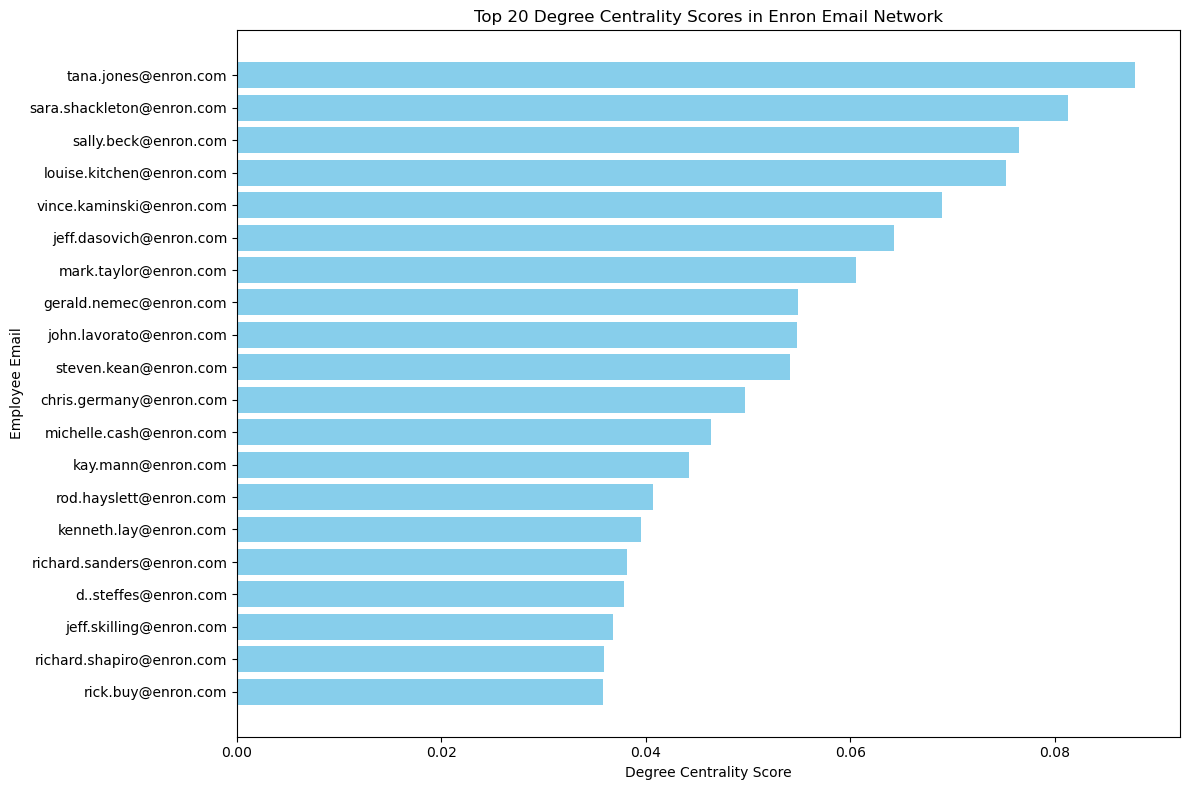

In [10]:
# Sort nodes by degree centrality scores in descending order
sorted_degree_centrality = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)

# Get the top 20 nodes with the highest degree centrality
top_20 = sorted_degree_centrality[:20]

# Extract names and scores for the bar graph
names = [x[0] for x in top_20]
scores = [x[1] for x in top_20]

# Create a bar graph
plt.figure(figsize=(12, 8))
plt.barh(names, scores, color='skyblue')
plt.xlabel('Degree Centrality Score')
plt.ylabel('Employee Email')
plt.title('Top 20 Degree Centrality Scores in Enron Email Network')
plt.gca().invert_yaxis()  # Invert y-axis to show the highest score at the top
plt.tight_layout()

# Show the bar graph
plt.show()

In [11]:
# Extract email addresses of the top 20
top_20_emails = [x[0] for x in top_20]

# Create a dictionary to store email-job_title pairs
email_to_job_title = {}

# Look through the entire 'From' list and match with the top 20 emails
for email in top_20_emails:
    # Find the job title for the email in the dataset
    job_title = data.loc[data['From'] == email, 'Job_Title'].drop_duplicates().values
    if len(job_title) > 0:
        email_to_job_title[email] = job_title[0]  # Take the first job title if there are duplicates
    else:
        email_to_job_title[email] = 'Unknown'  # If no job title is found, mark as 'Unknown'

# Create a DataFrame for the top 20 with job titles
top_20_with_titles = pd.DataFrame(top_20, columns=['email', 'degree_centrality'])
top_20_with_titles['Job_Title'] = top_20_with_titles['email'].map(email_to_job_title)

# Display the top 20 with job titles
# print(top_20_with_titles)
top_20_with_titles.head(20)

,email,degree_centrality,Job_Title
0,tana.jones@enron.com,0.087854,Unknown
1,sara.shackleton@enron.com,0.081270,Unknown
2,sally.beck@enron.com,0.076454,Chief Operating Officer
3,louise.kitchen@enron.com,0.075177,"President, Enron Online"
4,vince.kaminski@enron.com,0.068986,"Manager, Risk Management Head"
5,jeff.dasovich@enron.com,0.064269,Government Relation Executive
6,mark.taylor@enron.com,0.060535,Unknown
7,gerald.nemec@enron.com,0.054835,Unknown
8,john.lavorato@enron.com,0.054737,"CEO, Enron America"
9,steven.kean@enron.com,0.054049,"Vice President, Vice President & Chief of Staff"


1.2 in-degree centrality
- <i>In-degree: No. of emails received
- <i>High in-degree - authority figures

In [12]:
in_degree_centrality = nx.in_degree_centrality(G)  # Normalized in-degree centrality

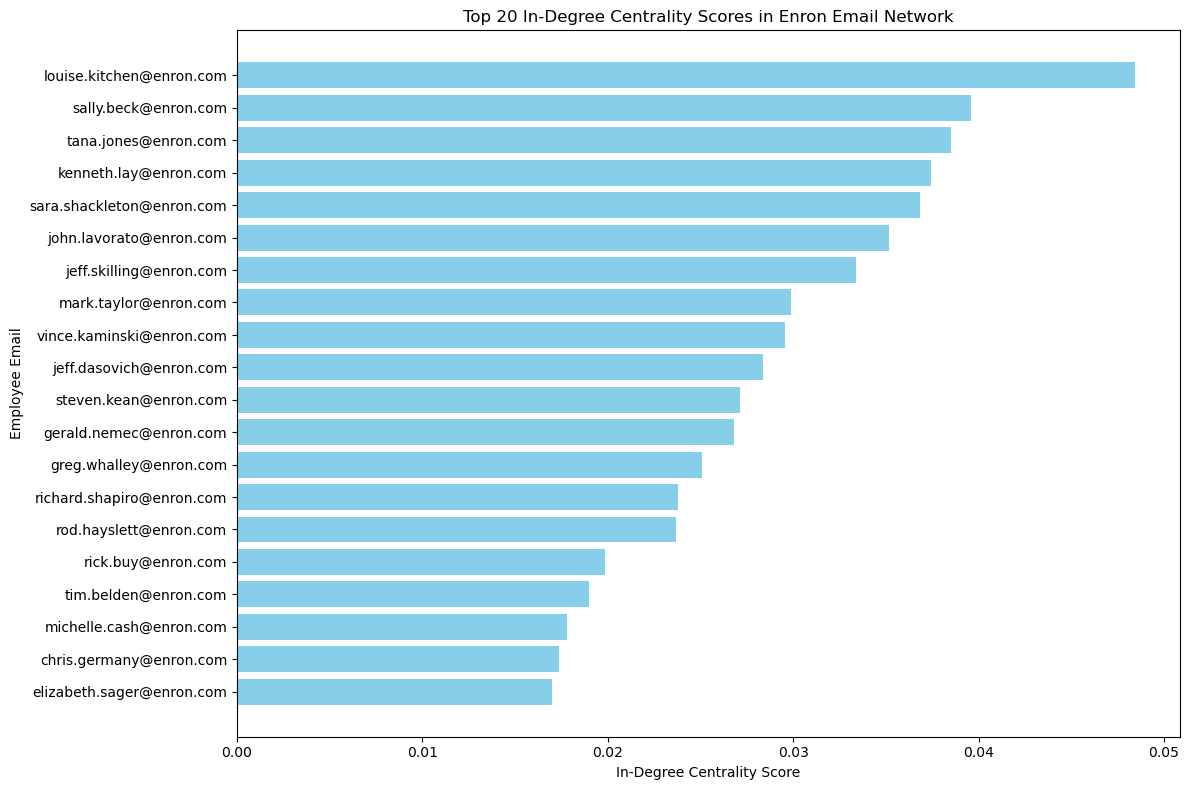

In [16]:
# Sort nodes by degree centrality scores in descending order
sorted_in_degree_centrality = sorted(in_degree_centrality.items(), key=lambda x: x[1], reverse=True)

# Get the top 20 nodes with the highest degree centrality
in_degree_top_20 = sorted_in_degree_centrality[:20]

# Extract names and scores for the bar graph
in_names = [x[0] for x in in_degree_top_20]
in_scores = [x[1] for x in in_degree_top_20]

# Create a bar graph
plt.figure(figsize=(12, 8))
plt.barh(in_names, in_scores, color='skyblue')
plt.xlabel('In-Degree Centrality Score')
plt.ylabel('Employee Email')
plt.title('Top 20 In-Degree Centrality Scores in Enron Email Network')
plt.gca().invert_yaxis()  # Invert y-axis to show the highest score at the top
plt.tight_layout()

# Show the bar graph
plt.show()

In [17]:
# Extract email addresses of the top 20
in_top_20_emails = [x[0] for x in in_degree_top_20]

# Create a dictionary to store email-job_title pairs
in_email_to_job_title = {}

# Look through the entire 'From' list and match with the top 20 emails
for email in in_top_20_emails:
    # Find the job title for the email in the dataset
    job_title = data.loc[data['From'] == email, 'Job_Title'].drop_duplicates().values
    if len(job_title) > 0:
        in_email_to_job_title[email] = job_title[0]  # Take the first job title if there are duplicates
    else:
        in_email_to_job_title[email] = 'Unknown'  # If no job title is found, mark as 'Unknown'

# Create a DataFrame for the top 20 with job titles
in_top_20_with_titles = pd.DataFrame(in_degree_top_20, columns=['email', 'in_degree_centrality'])
in_top_20_with_titles['Job_Title'] = in_top_20_with_titles['email'].map(in_email_to_job_title)

# Display the top 20 with job titles
# print(top_20_with_titles)
in_top_20_with_titles.head(20)

,email,in_degree_centrality,Job_Title
0,louise.kitchen@enron.com,0.048447,"President, Enron Online"
1,sally.beck@enron.com,0.039603,Chief Operating Officer
2,tana.jones@enron.com,0.038522,Unknown
3,kenneth.lay@enron.com,0.037441,CEO
4,sara.shackleton@enron.com,0.036851,Unknown
5,john.lavorato@enron.com,0.035181,"CEO, Enron America"
6,jeff.skilling@enron.com,0.033412,Unknown
7,mark.taylor@enron.com,0.029874,Unknown
8,vince.kaminski@enron.com,0.029579,"Manager, Risk Management Head"
9,jeff.dasovich@enron.com,0.028400,Government Relation Executive


Makes sense that these higher position people are listed higher in degree centrality

1.3 out-degree centrality
- <i>Out-degree: No. of emails sent<i>
- <i>High out-degree - information spreaders<i>

In [18]:
out_degree_centrality = nx.out_degree_centrality(G)  # Normalized out-degree centrality

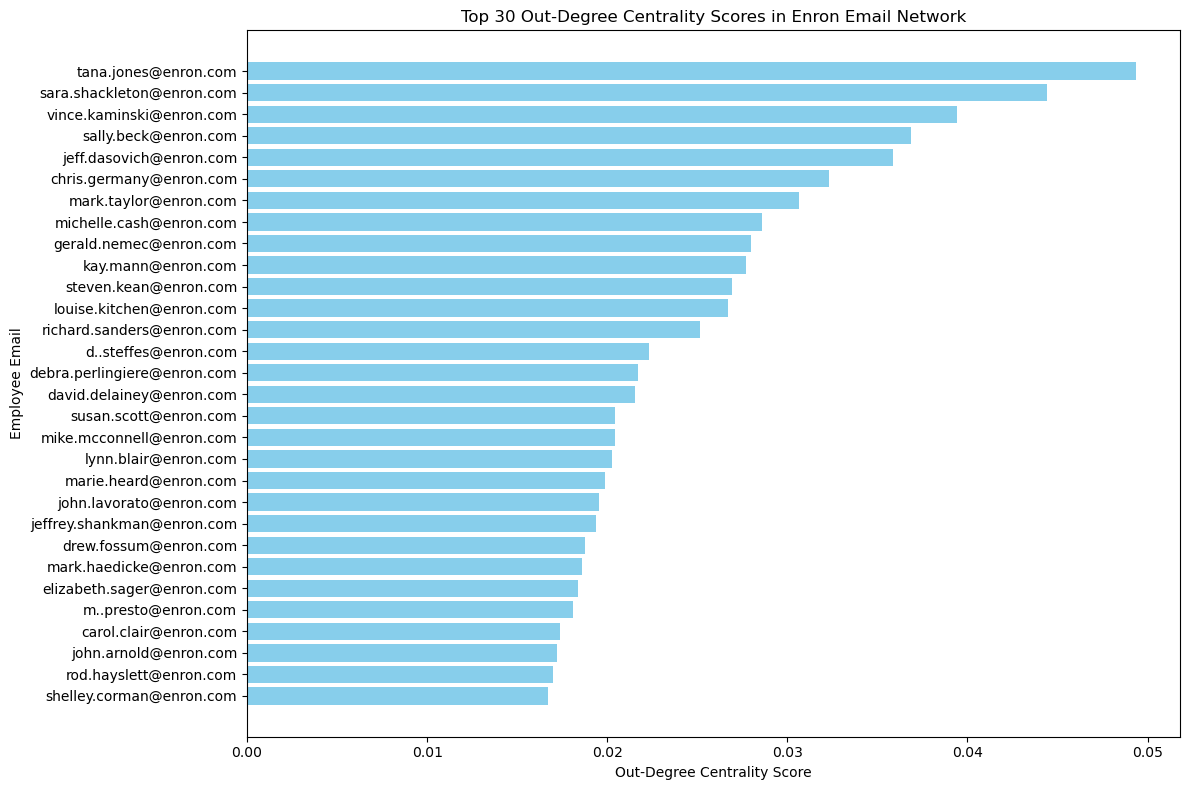

In [22]:
# Sort nodes by degree centrality scores in descending order
sorted_out_degree_centrality = sorted(out_degree_centrality.items(), key=lambda x: x[1], reverse=True)

# Get the top 20 nodes with the highest degree centrality
out_degree_top_20 = sorted_out_degree_centrality[:30]

# Extract names and scores for the bar graph
out_names = [x[0] for x in out_degree_top_20]
out_scores = [x[1] for x in out_degree_top_20]

# Create a bar graph
plt.figure(figsize=(12, 8))
plt.barh(out_names, out_scores, color='skyblue')
plt.xlabel('Out-Degree Centrality Score')
plt.ylabel('Employee Email')
plt.title('Top 30 Out-Degree Centrality Scores in Enron Email Network')
plt.gca().invert_yaxis()  # Invert y-axis to show the highest score at the top
plt.tight_layout()

# Show the bar graph
plt.show()

In [32]:
# Extract email addresses of the top 20
out_top_20_emails = [x[0] for x in out_degree_top_20]

# Create a dictionary to store email-job_title pairs
out_email_to_job_title = {}

# Look through the entire 'From' list and match with the top 20 emails
for email in out_top_20_emails:
    # Find the job title for the email in the dataset
    job_title = data.loc[data['From'] == email, 'Job_Title'].drop_duplicates().values
    if len(job_title) > 0:
        out_email_to_job_title[email] = job_title[0]  # Take the first job title if there are duplicates
    else:
        out_email_to_job_title[email] = 'Unknown'  # If no job title is found, mark as 'Unknown'

# Create a DataFrame for the top 20 with job titles
out_top_20_with_titles = pd.DataFrame(out_degree_top_20, columns=['email', 'out_degree_centrality'])
out_top_20_with_titles['Job_Title'] = out_top_20_with_titles['email'].map(out_email_to_job_title)

# Display the top 20 with job titles
# print(top_20_with_titles)
out_top_20_with_titles.head(30)

,email,out_degree_centrality,Job_Title
0,tana.jones@enron.com,0.049332,Unknown
1,sara.shackleton@enron.com,0.044418,Unknown
2,vince.kaminski@enron.com,0.039406,"Manager, Risk Management Head"
3,sally.beck@enron.com,0.036851,Chief Operating Officer
4,jeff.dasovich@enron.com,0.035869,Government Relation Executive
5,chris.germany@enron.com,0.032331,Unknown
6,mark.taylor@enron.com,0.030660,Unknown
7,michelle.cash@enron.com,0.028597,Unknown
8,gerald.nemec@enron.com,0.028007,Unknown
9,kay.mann@enron.com,0.027712,Unknown


interesting that high position people are the ones sending out more emails ..
- extended to top 30 but still all high positions, would think that "normal" people are the ones that would rank higher in this

2. Calculate betweenness centrality - 8mins to run
- <i>Betweenness centrality identifies individuals who act as bridges between different groups.<i>
- <i>Can be critical connectors in the network<i>
- <i>Highlighs bottlenecks and key intermediaries, may be essential for information flow and collaboration across departments<i>

In [25]:
# Calculate betweenness centrality
betweenness_centrality = nx.betweenness_centrality(G, normalized=True)  # Normalized by default

In [26]:
# # Calculate betweenness centrality
# betweenness_centrality = nx.betweenness_centrality(G)

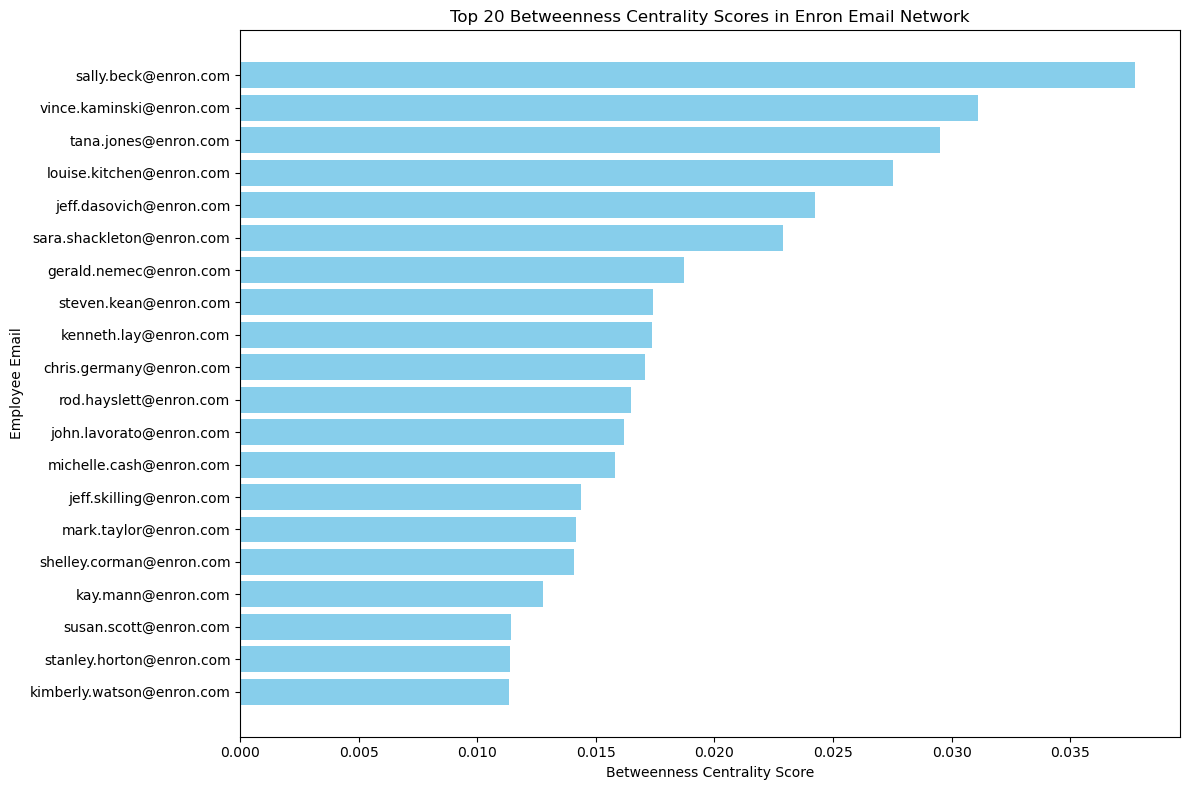

In [28]:
# Sort and print the top 20 individuals by betweenness centrality
sorted_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)

# Get the top 20 nodes with the highest betweenness centrality
betweenness_top_20 = sorted_betweenness[:20]

# Extract names and scores for the bar graph
betweenness_names = [x[0] for x in betweenness_top_20]
betweenness_scores = [x[1] for x in betweenness_top_20]

# Create a bar graph
plt.figure(figsize=(12, 8))
plt.barh(betweenness_names, betweenness_scores, color='skyblue')
plt.xlabel('Betweenness Centrality Score')
plt.ylabel('Employee Email')
plt.title('Top 20 Betweenness Centrality Scores in Enron Email Network')
plt.gca().invert_yaxis()  # Invert y-axis to show the highest score at the top
plt.tight_layout()

# Show the bar graph
plt.show()

In [33]:
# Extract email addresses of the top 20
betweenness_top_20_emails = [x[0] for x in betweenness_top_20]

# Create a dictionary to store email-job_title pairs
betweenness_email_to_job_title = {}

# Look through the entire 'From' list and match with the top 20 emails
for email in betweenness_top_20_emails:
    # Find the job title for the email in the dataset
    job_title = data.loc[data['From'] == email, 'Job_Title'].drop_duplicates().values
    if len(job_title) > 0:
        betweenness_email_to_job_title[email] = job_title[0]  # Take the first job title if there are duplicates
    else:
        betweenness_email_to_job_title[email] = 'Unknown'  # If no job title is found, mark as 'Unknown'

# Create a DataFrame for the top 20 with job titles
betweenness_top_20_with_titles = pd.DataFrame(betweenness_top_20, columns=['email', 'between_centrality'])
betweenness_top_20_with_titles['Job_Title'] = betweenness_top_20_with_titles['email'].map(betweenness_email_to_job_title)

# Display the top 20 with job titles
# print(top_20_with_titles)
betweenness_top_20_with_titles.head(20)

,email,between_centrality,Job_Title
0,sally.beck@enron.com,0.037744,Chief Operating Officer
1,vince.kaminski@enron.com,0.031118,"Manager, Risk Management Head"
2,tana.jones@enron.com,0.029499,Unknown
3,louise.kitchen@enron.com,0.027543,"President, Enron Online"
4,jeff.dasovich@enron.com,0.024247,Government Relation Executive
5,sara.shackleton@enron.com,0.022904,Unknown
6,gerald.nemec@enron.com,0.018697,Unknown
7,steven.kean@enron.com,0.017413,"Vice President, Vice President & Chief of Staff"
8,kenneth.lay@enron.com,0.017376,CEO
9,chris.germany@enron.com,0.017092,Unknown


higher positions still seen over here
- no.2 - Manager, Risk Management Head | no.4 Government Relation Executive - seems to be more relevant in this case, since i would assume they would be involved more in the email chain

3. Calculate Closeness Centrality
- <i>Measures how close a node is to all other nodes in the network<i>
- <i>Closeness centrality measures how quickly an individual can communicate with others in the network.<i>
- <i>High closeness - individuals are centrally located in the network, can quickly reach out to others and disseminate information<i>
- <i>Identifies efficient communicators - ideal for broadcasting information or coordinating tasks | often central figures in the network<i>

In [30]:
# Calculate closeness centrality
closeness_centrality = nx.closeness_centrality(G)

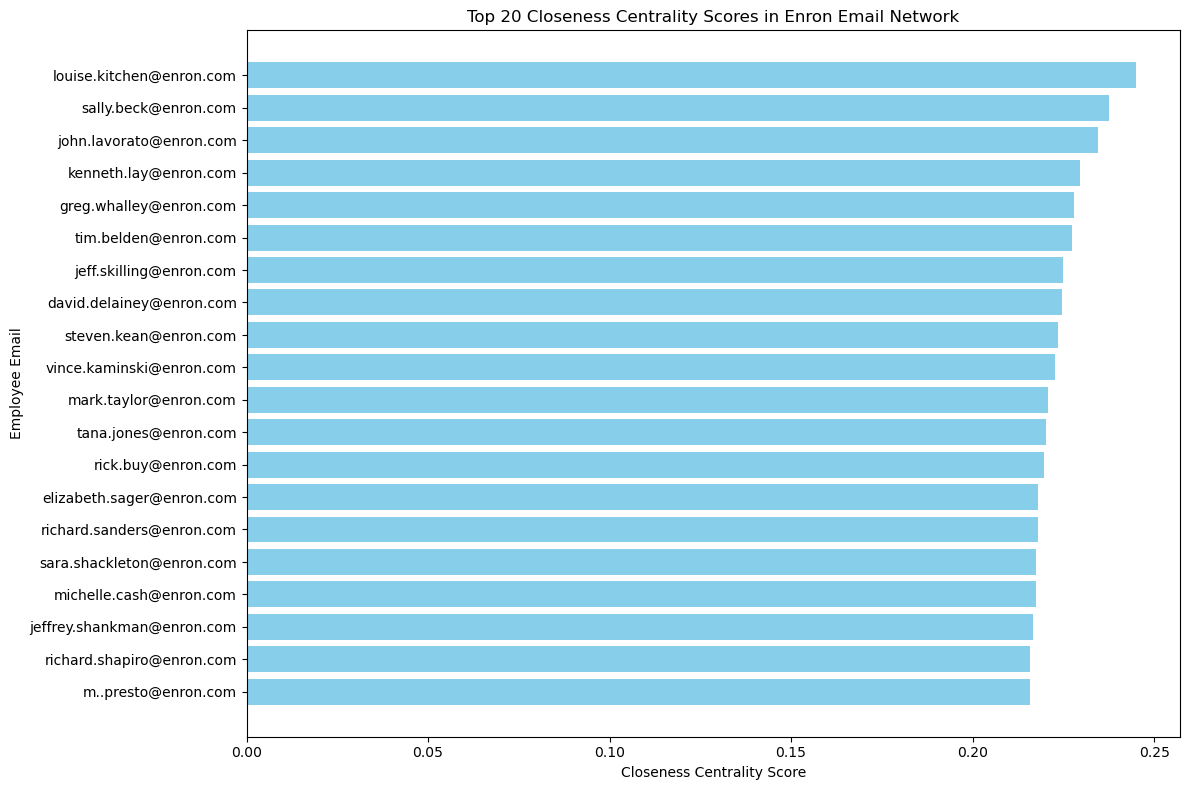

In [31]:
# Sort and print the top 20 individuals by betweenness centrality
sorted_closeness = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)

# Get the top 20 nodes with the highest betweenness centrality
closeness_top_20 = sorted_closeness[:20]

# Extract names and scores for the bar graph
closeness_names = [x[0] for x in closeness_top_20]
closeness_scores = [x[1] for x in closeness_top_20]

# Create a bar graph
plt.figure(figsize=(12, 8))
plt.barh(closeness_names, closeness_scores, color='skyblue')
plt.xlabel('Closeness Centrality Score')
plt.ylabel('Employee Email')
plt.title('Top 20 Closeness Centrality Scores in Enron Email Network')
plt.gca().invert_yaxis()  # Invert y-axis to show the highest score at the top
plt.tight_layout()

# Show the bar graph
plt.show()

In [34]:
# Extract email addresses of the top 20
closeness_top_20_emails = [x[0] for x in closeness_top_20]

# Create a dictionary to store email-job_title pairs
closeness_email_to_job_title = {}

# Look through the entire 'From' list and match with the top 20 emails
for email in closeness_top_20_emails:
    # Find the job title for the email in the dataset
    job_title = data.loc[data['From'] == email, 'Job_Title'].drop_duplicates().values
    if len(job_title) > 0:
        closeness_email_to_job_title[email] = job_title[0]  # Take the first job title if there are duplicates
    else:
        closeness_email_to_job_title[email] = 'Unknown'  # If no job title is found, mark as 'Unknown'

# Create a DataFrame for the top 20 with job titles
closeness_top_20_with_titles = pd.DataFrame(closeness_top_20, columns=['email', 'closeness_centrality'])
closeness_top_20_with_titles['Job_Title'] = closeness_top_20_with_titles['email'].map(closeness_email_to_job_title)

# Display the top 20 with job titles
# print(top_20_with_titles)
closeness_top_20_with_titles.head(20)

,email,closeness_centrality,Job_Title
0,louise.kitchen@enron.com,0.244880,"President, Enron Online"
1,sally.beck@enron.com,0.237499,Chief Operating Officer
2,john.lavorato@enron.com,0.234654,"CEO, Enron America"
3,kenneth.lay@enron.com,0.229644,CEO
4,greg.whalley@enron.com,0.227792,Unknown
5,tim.belden@enron.com,0.227394,Unknown
6,jeff.skilling@enron.com,0.224844,Unknown
7,david.delainey@enron.com,0.224725,"CEO, Enron North America and Enron Energy Serv..."
8,steven.kean@enron.com,0.223568,"Vice President, Vice President & Chief of Staff"
9,vince.kaminski@enron.com,0.222570,"Manager, Risk Management Head"


Final Thoughts:
- in general, high position employees in Enron are seen - they are very much involved in email communications
- can choose to find out where the "normal" employees reside in the overall rankings

random charts

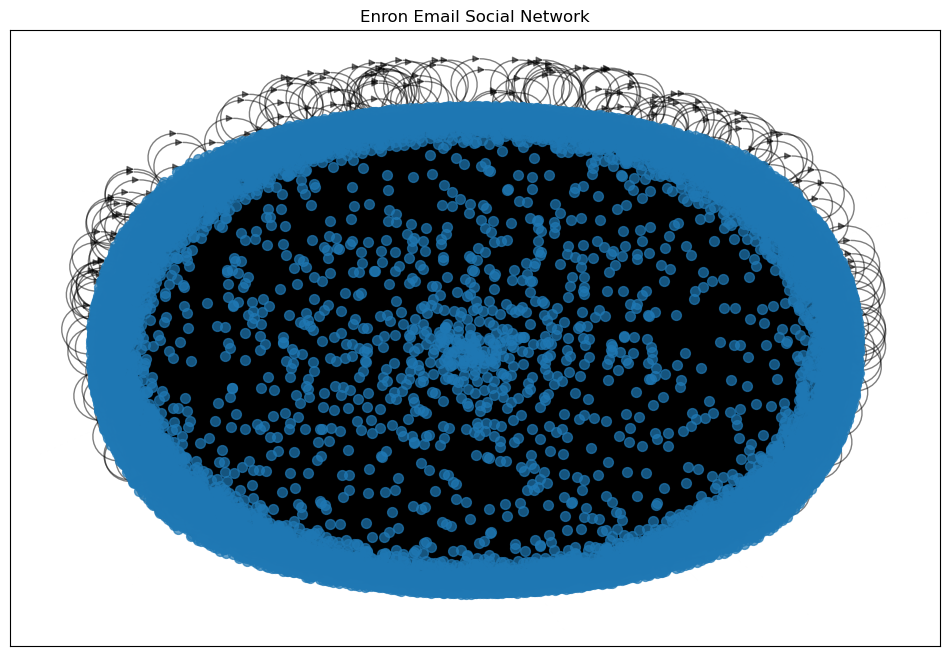

In [ ]:

# Draw the network
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=0.5)  # Force-directed layout
nx.draw_networkx_nodes(G, pos, node_size=50, alpha=0.7)
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.title("Enron Email Social Network")
plt.show()


In [56]:

# Sort by highest centrality scores
top_nodes = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top 10 most central nodes:", top_nodes)


Top 10 most central nodes: [('tana.jones@enron.com', 0.08785377358490566), ('sara.shackleton@enron.com', 0.08126965408805031), ('sally.beck@enron.com', 0.07645440251572327), ('louise.kitchen@enron.com', 0.07517688679245284), ('vince.kaminski@enron.com', 0.06898584905660378), ('jeff.dasovich@enron.com', 0.06426886792452831), ('mark.taylor@enron.com', 0.060534591194968554), ('gerald.nemec@enron.com', 0.05483490566037736), ('john.lavorato@enron.com', 0.05473663522012579), ('steven.kean@enron.com', 0.05404874213836478)]


random chart of top 70 degree centrality - hard to interpret

ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

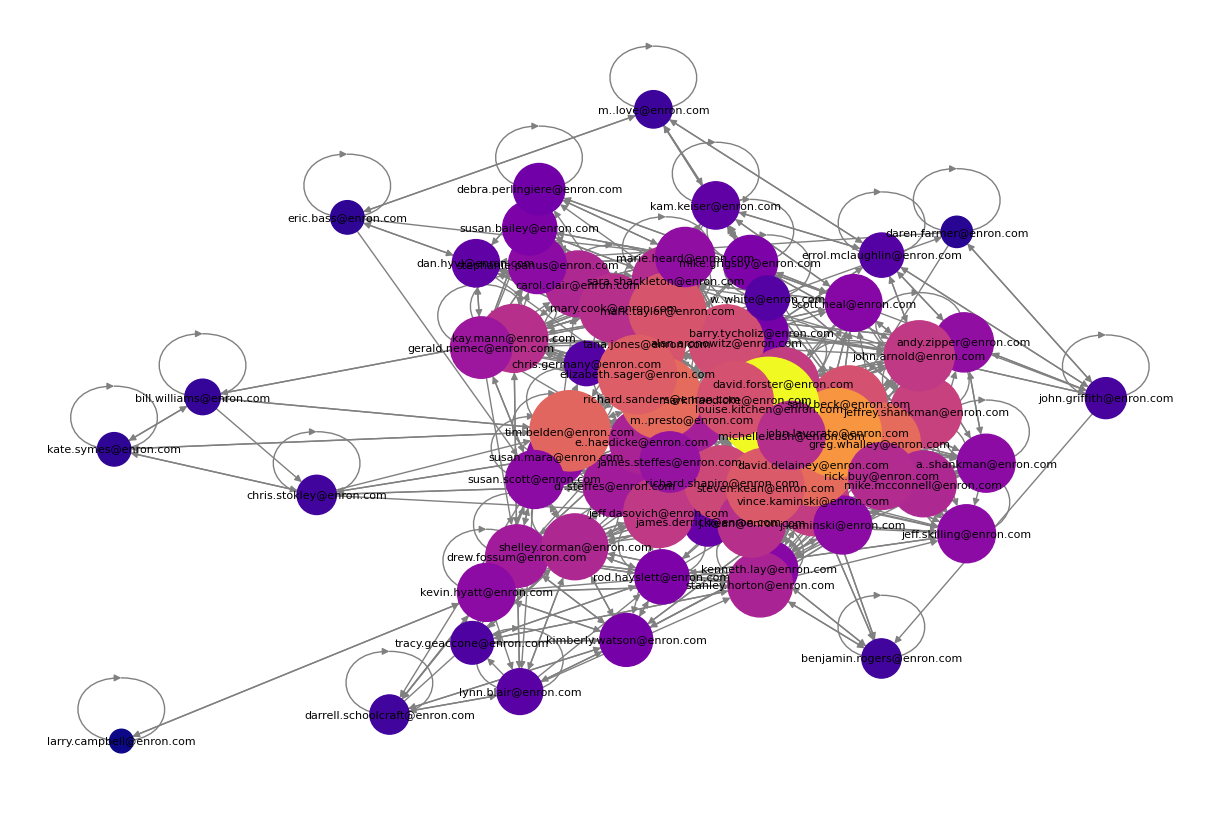

In [60]:
# Get the top 70 employees based on degree centrality
top_70 = sorted(degree_centrality, key=degree_centrality.get, reverse=True)[:70]

# Create a subgraph with the top 70 employees
subgraph = G.subgraph(top_70)

# Calculate degree centrality for the subgraph
subgraph_degree_centrality = nx.degree_centrality(subgraph)

# Set node size and color based on degree centrality
node_size = [v * 5000 for v in subgraph_degree_centrality.values()]  # Scale for visibility
node_color = [v * 100 for v in subgraph_degree_centrality.values()]  # Scale for color intensity

# Draw the graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(subgraph)  # Layout for positioning nodes
nx.draw(subgraph, pos, node_size=node_size, node_color=node_color, cmap=plt.cm.plasma, with_labels=True, font_size=8, font_color='black', edge_color='gray')

# Add a colorbar
sm = plt.cm.ScalarMappable(cmap=plt.cm.plasma, norm=plt.Normalize(vmin=min(node_color), vmax=max(node_color)))
sm.set_array([])
plt.colorbar(sm, label='Degree Centrality')

# Show the graph
plt.title('Top 70 Employees by Degree Centrality')